<a href="https://colab.research.google.com/github/shoofiash/BootcampTask/blob/main/Assignment%2018%20-%20Case_Study(Customer_Lifetime_Values).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Business Development and Marketing Team of Olist E-commerce want to develop loyalty program. But they don't know which customers that are suit with this program. Therefore, data scientist need to make segmentation of customers by calculate the customer lifetime value. From customer lifetime value, data scientist can figure out which customer that contribute more profit to the company

# **Metadata**

Here are some types of data that be used on calculate customer lifetime value:
- customer_id: unique number of each order
- customer_unique_id: unique identifier of a customer
- customer_zip_code_prefix: first five digits of customer zip code
- customer_city: customer's city name
- customer_state: customer's state
- order_id: order unique identifier
- order_status: reference to the order status (delivered, shipped, etc)
- order_purchase_timestamp: shows the purchase timestamp
- review_score: note ranging from 1 to 5 given by the customer on a satisfaction survey
- payment_type: method of payment chosen by customer
- payment_value: transaction value
- order_item_id: sequential number identifying number of items included in the same order
- product_id: product unique identifier


# **Install the package**

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 8.3 MB/s 


In [2]:
# numpy for array manipulation
import numpy as np
# pandas for dataframe manipulation
import pandas as pd
# matplotlib for data visualization
import matplotlib.pyplot as plt

#split training set and test set
from sklearn.model_selection import train_test_split
# import regression model
from sklearn.linear_model import LinearRegression
# import metrics module from scikit-learn
from sklearn import metrics

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

# seaborn for preety data visualization
import seaborn as sns

# import datetime for date manipulation
import datetime as dt

# **Load Dataset**

**Customer Dataset**

This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location. In this dataset, each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store.

In [3]:
customer = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_customers_dataset.csv")
customer

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


**Order Items Dataset**

This dataset includes data about the items purchased within each order.

For example:
The order_id = 00143d0f86d6fbd9f9b38ab440ac16f5 has 3 items (same product). Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.

The total order_item value is: 21.33 * 3 = 63.99

The total freight value is: 15.10 * 3 = 45.30

The total order value (product + freight) is: 45.30 + 63.99 = 109.29

In [4]:
orderitem = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_items_dataset.csv")
orderitem

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [5]:
orderitem_new = orderitem
columns = ["seller_id","shipping_limit_date", "price", "freight_value"]
orderitem_new.drop(columns, inplace=True, axis=1)
orderitem_new

,order_id,order_item_id,product_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089
...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e


Drop columns that are not really necessary. Here, we only need order_id, order_item_id, and product_id

**Payments Dataset**

This dataset includes data about the orders payment options

In [6]:
payment_type = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_payments_dataset.csv")
payment_type

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [7]:
payment_new = payment_type
columns_1 = ["payment_sequential","payment_installments"]
payment_new.drop(columns_1, inplace=True, axis=1)
payment_new

,order_id,payment_type,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,credit_card,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,credit_card,65.71
3,ba78997921bbcdc1373bb41e913ab953,credit_card,107.78
4,42fdf880ba16b47b59251dd489d4441a,credit_card,128.45
...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,boleto,363.31
103882,7b905861d7c825891d6347454ea7863f,credit_card,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,credit_card,47.77
103884,b8b61059626efa996a60be9bb9320e10,credit_card,369.54


Drop columns that are not really necessary. Here, we only need order_id, payment_type, and payment_value (total purchase of order)

**Order Reviews Dataset**

This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

In [8]:
review = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_reviews_dataset.csv")
review

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [9]:
columns_2 = ["review_id","review_comment_title", "review_comment_message", "review_creation_date", "review_answer_timestamp"]
review_new = review
review_new.drop(columns_2, inplace=True, axis=1)
review_new

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,5
99996,55d4004744368f5571d1f590031933e4,5
99997,7725825d039fc1f0ceb7635e3f7d9206,4
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1


Drop columns that are not really necessary. Here, we only need order_id and review score (to measure satisfaction of customer)

**Order Dataset**

This is the core of dataset. This dataset detailed more about each order of customer_id

In [10]:
order = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_orders_dataset.csv")
order

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [11]:
order_new = order
columns_3 = ["order_approved_at","order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]
order_new.drop(columns_3, inplace=True, axis=1)
order_new

,order_id,customer_id,order_status,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27


Drop columns that are not really necessary. Here, we only need order_id, customer_id, order_status, and order_purchase_timestamp (to measure recency of customer)

**Products Dataset**

This dataset includes data about the products sold by Olist

In [12]:
product = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_products_dataset.csv")
product

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [13]:
product_new = product
columns_4 = ["product_name_lenght","product_description_lenght", "product_photos_qty", "product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]
product_new.drop(columns_4, inplace=True, axis=1)
product_new

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer
3,cef67bcfe19066a932b7673e239eb23d,bebes
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas
...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios


Drop columns that are not really necessary. Here, we only need product_id and product_category_name

**Then we join the dataset by using order_id and customer_id**

In [14]:
df = pd.merge(customer, order_new, on= "customer_id", how="inner")
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30
...,...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33


In [15]:
df = pd.merge(df, review_new, on= "order_id", how="inner")
dp = pd.merge(df.drop_duplicates(), review_new,how='inner',on='order_id')
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,4
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,5
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,5
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,5
...,...,...,...,...,...,...,...,...,...
99995,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,4
99996,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,5
99997,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,1
99998,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,5


In [16]:
df = pd.merge(df, payment_new, on= "order_id", how="inner")
dp = pd.merge(df.drop_duplicates(),payment_new,how='inner',on='order_id')
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score,payment_type,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,4,credit_card,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,5,credit_card,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,5,credit_card,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,5,credit_card,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,5,credit_card,252.25
...,...,...,...,...,...,...,...,...,...,...,...
104480,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,4,credit_card,88.78
104481,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,5,credit_card,129.06
104482,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,1,credit_card,56.04
104483,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,5,credit_card,711.07


In [17]:
df = pd.merge(df, orderitem_new, on= "order_id", how="inner")
dp = pd.merge(df.drop_duplicates(),orderitem_new,how='inner',on='order_id')
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score,payment_type,payment_value,order_item_id,product_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,4,credit_card,146.87,1,a9516a079e37a9c9c36b9b78b10169e8
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,5,credit_card,335.48,1,4aa6014eceb682077f9dc4bffebc05b0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,5,credit_card,157.73,1,bd07b66896d6f1494f5b86251848ced7
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,5,credit_card,173.30,1,a5647c44af977b148e0a3a4751a09e2e
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,5,credit_card,252.25,1,9391a573abe00141c56e38d84d7d5b3b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,4,credit_card,88.78,1,ccb4503d9d43d245d3b295d0544f988b
118311,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,5,credit_card,129.06,1,9ede6b0570a75a4b9de4f383329f99ee
118312,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,1,credit_card,56.04,1,7a5d2e1e131a860ae7d18f6fffa9d689
118313,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,5,credit_card,711.07,1,f819f0c84a64f02d3a5606ca95edd272


In [18]:
df = pd.merge(df, product_new, on= "product_id", how="inner")
dp = pd.merge(df.drop_duplicates(),product_new,how='inner',on='product_id')
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score,payment_type,payment_value,order_item_id,product_id,product_category_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,4,credit_card,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,1,credit_card,275.79,1,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,1,credit_card,275.79,2,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,3,credit_card,140.61,1,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,4,credit_card,137.58,1,a9516a079e37a9c9c36b9b78b10169e8,moveis_escritorio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,da37711b17efd5f2539e8196ab215f04,5f2971f9805e3ccb030226e30c8e8390,4313,sao paulo,SP,c8203bb57639618630affac9e8e923dd,delivered,2017-03-27 23:04:18,4,credit_card,30.95,1,aea06073397f809424f946979354c9f0,pet_shop
118311,184e0c2cfc746789643521df0e9ff904,c64ede6d0ae8901b1b6fb03528c1b7e6,68660,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,delivered,2017-12-07 23:55:46,4,credit_card,304.11,1,bbf975bffd2ae9ee52f513ae5c8a4b27,beleza_saude
118312,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,delivered,2018-04-04 17:50:52,5,credit_card,92.36,1,f6e0a9ce8a6e91c3a0ca2d3005911d20,fashion_bolsas_e_acessorios
118313,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14 12:04:09,1,credit_card,167.79,1,c98bf47f7bea8f3aee82fa023786b8a1,eletronicos


# **Data Inspection**

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               118315 non-null  object 
 1   customer_unique_id        118315 non-null  object 
 2   customer_zip_code_prefix  118315 non-null  int64  
 3   customer_city             118315 non-null  object 
 4   customer_state            118315 non-null  object 
 5   order_id                  118315 non-null  object 
 6   order_status              118315 non-null  object 
 7   order_purchase_timestamp  118315 non-null  object 
 8   review_score              118315 non-null  int64  
 9   payment_type              118315 non-null  object 
 10  payment_value             118315 non-null  float64
 11  order_item_id             118315 non-null  int64  
 12  product_id                118315 non-null  object 
 13  product_category_name     116606 non-null  o

The datatype of order_purchase_timestamp is not correct. Therefore, we need to change the datatype into timestamp. Also, there are missing value on product_category_name

In [20]:
df.isnull().sum()

customer_id                    0
customer_unique_id             0
customer_zip_code_prefix       0
customer_city                  0
customer_state                 0
order_id                       0
order_status                   0
order_purchase_timestamp       0
review_score                   0
payment_type                   0
payment_value                  0
order_item_id                  0
product_id                     0
product_category_name       1709
dtype: int64

Then, lets drop the missing value

In [21]:
df.drop('product_category_name', axis=1, inplace=True)

In [22]:
df.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_id                    0
order_status                0
order_purchase_timestamp    0
review_score                0
payment_type                0
payment_value               0
order_item_id               0
product_id                  0
dtype: int64

Let's check again

In [23]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score,payment_type,payment_value,order_item_id,product_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,4,credit_card,146.87,1,a9516a079e37a9c9c36b9b78b10169e8
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,1,credit_card,275.79,1,a9516a079e37a9c9c36b9b78b10169e8
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,1,credit_card,275.79,2,a9516a079e37a9c9c36b9b78b10169e8
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,3,credit_card,140.61,1,a9516a079e37a9c9c36b9b78b10169e8
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,4,credit_card,137.58,1,a9516a079e37a9c9c36b9b78b10169e8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,da37711b17efd5f2539e8196ab215f04,5f2971f9805e3ccb030226e30c8e8390,4313,sao paulo,SP,c8203bb57639618630affac9e8e923dd,delivered,2017-03-27 23:04:18,4,credit_card,30.95,1,aea06073397f809424f946979354c9f0
118311,184e0c2cfc746789643521df0e9ff904,c64ede6d0ae8901b1b6fb03528c1b7e6,68660,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,delivered,2017-12-07 23:55:46,4,credit_card,304.11,1,bbf975bffd2ae9ee52f513ae5c8a4b27
118312,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,delivered,2018-04-04 17:50:52,5,credit_card,92.36,1,f6e0a9ce8a6e91c3a0ca2d3005911d20
118313,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14 12:04:09,1,credit_card,167.79,1,c98bf47f7bea8f3aee82fa023786b8a1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   customer_id               118315 non-null  object 
 1   customer_unique_id        118315 non-null  object 
 2   customer_zip_code_prefix  118315 non-null  int64  
 3   customer_city             118315 non-null  object 
 4   customer_state            118315 non-null  object 
 5   order_id                  118315 non-null  object 
 6   order_status              118315 non-null  object 
 7   order_purchase_timestamp  118315 non-null  object 
 8   review_score              118315 non-null  int64  
 9   payment_type              118315 non-null  object 
 10  payment_value             118315 non-null  float64
 11  order_item_id             118315 non-null  int64  
 12  product_id                118315 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory us

The next step is we need to change datatype of order_purchase_timestamp

In [25]:
df["order_purchase_timestamp"] = pd.to_datetime(pd.to_datetime(df["order_purchase_timestamp"]).dt.date)
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score,payment_type,payment_value,order_item_id,product_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,4,credit_card,146.87,1,a9516a079e37a9c9c36b9b78b10169e8
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,1,credit_card,275.79,1,a9516a079e37a9c9c36b9b78b10169e8
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,1,credit_card,275.79,2,a9516a079e37a9c9c36b9b78b10169e8
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07,3,credit_card,140.61,1,a9516a079e37a9c9c36b9b78b10169e8
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03,4,credit_card,137.58,1,a9516a079e37a9c9c36b9b78b10169e8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,da37711b17efd5f2539e8196ab215f04,5f2971f9805e3ccb030226e30c8e8390,4313,sao paulo,SP,c8203bb57639618630affac9e8e923dd,delivered,2017-03-27,4,credit_card,30.95,1,aea06073397f809424f946979354c9f0
118311,184e0c2cfc746789643521df0e9ff904,c64ede6d0ae8901b1b6fb03528c1b7e6,68660,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,delivered,2017-12-07,4,credit_card,304.11,1,bbf975bffd2ae9ee52f513ae5c8a4b27
118312,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,delivered,2018-04-04,5,credit_card,92.36,1,f6e0a9ce8a6e91c3a0ca2d3005911d20
118313,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14,1,credit_card,167.79,1,c98bf47f7bea8f3aee82fa023786b8a1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_id               118315 non-null  object        
 1   customer_unique_id        118315 non-null  object        
 2   customer_zip_code_prefix  118315 non-null  int64         
 3   customer_city             118315 non-null  object        
 4   customer_state            118315 non-null  object        
 5   order_id                  118315 non-null  object        
 6   order_status              118315 non-null  object        
 7   order_purchase_timestamp  118315 non-null  datetime64[ns]
 8   review_score              118315 non-null  int64         
 9   payment_type              118315 non-null  object        
 10  payment_value             118315 non-null  float64       
 11  order_item_id             118315 non-null  int64         
 12  pr

The next step is we need to check unique of feature

In [27]:
for x in df.columns:
  print(f"unique of {x}")
  print(f"{df[x].unique()}")
  print()

unique of customer_id
['06b8999e2fba1a1fbc88172c00ba8bc7' '8912fc0c3bbf1e2fbf35819e21706718'
 'f0ac8e5a239118859b1734e1087cbb1f' ... '184e0c2cfc746789643521df0e9ff904'
 '821a7275a08f32975caceff2e08ea262' '1ed0c832c2dd99570a59260e71768bdf']

unique of customer_unique_id
['861eff4711a542e4b93843c6dd7febb0' '9eae34bbd3a474ec5d07949ca7de67c0'
 '3c799d181c34d51f6d44bbbc563024db' ... 'c64ede6d0ae8901b1b6fb03528c1b7e6'
 '046470763123d3d6364f89095b4e47ab' '82d46759af0369aad49084bacf85a6c3']

unique of customer_zip_code_prefix
[14409 68030 92480 ...  5315  4319 87145]

unique of customer_city
['franca' 'santarem' 'nova santa rita' ... 'sao sebastiao do paraiba'
 'pacotuba' 'balbinos']

unique of customer_state
['SP' 'PA' 'RS' 'RJ' 'SC' 'MG' 'MT' 'BA' 'ES' 'PR' 'MS' 'CE' 'MA' 'RN'
 'TO' 'RR' 'PB' 'DF' 'GO' 'PE' 'PI' 'RO' 'AL' 'SE' 'AM' 'AP' 'AC']

unique of order_id
['00e7ee1b050b8499577073aeb2a297a1' 'c1d2b34febe9cd269e378117d6681172'
 'b1a5d5365d330d10485e0203d54ab9e8' ... '45b3000bcd10464ac17

In this dataset, we only focused on delivered status (order_status)

In [28]:
df = df[(df['order_status'] == "delivered")]
df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,review_score,payment_type,payment_value,order_item_id,product_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,4,credit_card,146.87,1,a9516a079e37a9c9c36b9b78b10169e8
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,1,credit_card,275.79,1,a9516a079e37a9c9c36b9b78b10169e8
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09,1,credit_card,275.79,2,a9516a079e37a9c9c36b9b78b10169e8
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07,3,credit_card,140.61,1,a9516a079e37a9c9c36b9b78b10169e8
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03,4,credit_card,137.58,1,a9516a079e37a9c9c36b9b78b10169e8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,da37711b17efd5f2539e8196ab215f04,5f2971f9805e3ccb030226e30c8e8390,4313,sao paulo,SP,c8203bb57639618630affac9e8e923dd,delivered,2017-03-27,4,credit_card,30.95,1,aea06073397f809424f946979354c9f0
118311,184e0c2cfc746789643521df0e9ff904,c64ede6d0ae8901b1b6fb03528c1b7e6,68660,sao miguel do guama,PA,45b3000bcd10464ac178f32cd783fc83,delivered,2017-12-07,4,credit_card,304.11,1,bbf975bffd2ae9ee52f513ae5c8a4b27
118312,821a7275a08f32975caceff2e08ea262,046470763123d3d6364f89095b4e47ab,5734,sao paulo,SP,49645a8902c1ba980836b7bff991d69f,delivered,2018-04-04,5,credit_card,92.36,1,f6e0a9ce8a6e91c3a0ca2d3005911d20
118313,1ed0c832c2dd99570a59260e71768bdf,82d46759af0369aad49084bacf85a6c3,37610,bom repouso,MG,51c6d2f460589fa7b65f2da51e860206,delivered,2017-11-14,1,credit_card,167.79,1,c98bf47f7bea8f3aee82fa023786b8a1


# **Data Exploration**

In [29]:
df.rename(columns = {'customer_unique_id':'CustomerID'}, inplace = True)

In [30]:
# Count unique user for each state
df.groupby(
    'customer_state', as_index=False
).CustomerID.nunique().sort_values(
    by='CustomerID', ascending = False
)

,customer_state,CustomerID
25,SP,39155
18,RJ,11917
10,MG,11001
22,RS,5168
17,PR,4769
23,SC,3449
4,BA,3158
6,DF,2019
7,ES,1928
8,GO,1895


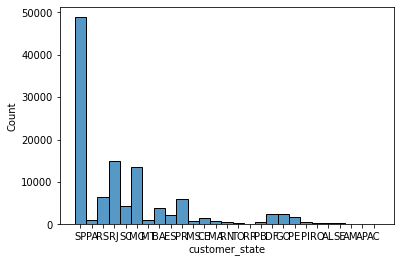

In [31]:
sns.histplot(x = "customer_state", data = df);

From the graphic, it can be infered that most of customer from SP state. 

Let's check review score to look how well Olist E-commerce serve their customer

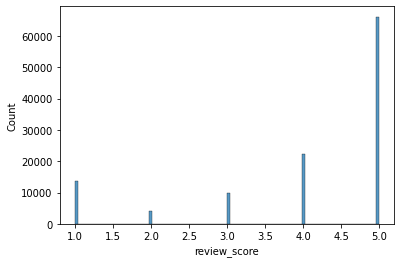

In [32]:
sns.histplot(x = "review_score", data = df);

Most of customer satisfied with performance of Olist E-commerce

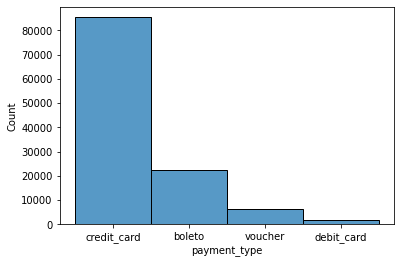

In [33]:
sns.histplot(x = "payment_type", data = df);

Most of customer use credit card as payment method that they are choose.

# **1. Create RFM Segmentation**

We need to filter required columns for calculating CLTV and RFM. We only need customer_unique_id, order_id, order_purchase_timestamp, order_item_id, and payment_value.
- customer_unique_id will help us to define the customers because each customers have their unique id
- order_id will help us count number of transaction
- order_purchase_timestamp will help us to calculate numbers of days customer stayed with our product
- order_item_id is the quantity purchased in each transaction
- payment_value will help us to calculate the total purchased amount. This variable already the GMV of customers

In [34]:
# select certain column
df = df[[
    "CustomerID","order_id",
    "order_purchase_timestamp","order_item_id","payment_value"
]]

In [35]:
data = df[[
    "CustomerID","order_id",
    "order_purchase_timestamp","order_item_id","payment_value"
]]

In [36]:
# rename the column to make it easier
df.rename(columns = {'order_id':'InvoiceNo', 'order_purchase_timestamp':'InvoiceDate','order_item_id':'Quantity','payment_value':'GMV'}, inplace = True)

In [37]:
df

,CustomerID,InvoiceNo,InvoiceDate,Quantity,GMV
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,1,146.87
1,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,2017-11-09,1,275.79
2,9eae34bbd3a474ec5d07949ca7de67c0,c1d2b34febe9cd269e378117d6681172,2017-11-09,2,275.79
3,3c799d181c34d51f6d44bbbc563024db,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07,1,140.61
4,23397e992b09769faf5e66f9e171a241,2e604b3614664aa66867856dba7e61b7,2018-02-03,1,137.58
...,...,...,...,...,...
118310,5f2971f9805e3ccb030226e30c8e8390,c8203bb57639618630affac9e8e923dd,2017-03-27,1,30.95
118311,c64ede6d0ae8901b1b6fb03528c1b7e6,45b3000bcd10464ac178f32cd783fc83,2017-12-07,1,304.11
118312,046470763123d3d6364f89095b4e47ab,49645a8902c1ba980836b7bff991d69f,2018-04-04,1,92.36
118313,82d46759af0369aad49084bacf85a6c3,51c6d2f460589fa7b65f2da51e860206,2017-11-14,1,167.79


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115728 entries, 0 to 118314
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   115728 non-null  object        
 1   InvoiceNo    115728 non-null  object        
 2   InvoiceDate  115728 non-null  datetime64[ns]
 3   Quantity     115728 non-null  int64         
 4   GMV          115728 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 9.3+ MB


First, we need to calculate customer's recency

In [39]:
df_recency = df.groupby(by="CustomerID",
                        as_index=False)["InvoiceDate"].max()
df_recency.columns = ["CustomerID", "LastPurchaseDate"]
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,CustomerID,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,114
2,0000f46a3911fa3c0805444483337064,2017-03-10,537
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,321
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,288


Then, we calculate frequency of customer transaction in ordering/buying some product from the Olist E-commerce

In [40]:
frequency_df = df.drop_duplicates().groupby(
    by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


The next step is calculate monetary value of customer spend on purchasing products from Olist E-commerce

In [41]:
monetary_df = df.groupby(by='CustomerID', as_index=False)['GMV'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


Merging all three columns in one dataframe

In [42]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


Ranking the customer

In [43]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,75.998372,42.493332,42.493332
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,74.968399,42.493332,42.493332
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3.465378,42.493332,42.493332
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,28.565537,42.493332,42.493332
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,33.580427,42.493332,42.493332
...,...,...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,4134.84,12.144892,90.639695,90.639695
93353,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,41.322093,42.493332,42.493332
93354,ffff371b4d645b6ecea244b27531430a,568,1,112.46,1.470242,42.493332,42.493332
93355,ffff5962728ec6157033ef9805bacc48,119,1,133.69,73.619205,42.493332,42.493332


Calculate RFM. Formula used for calculating rfm score is: 0,15 x recency score + 0,28 x frequency score + 0,57 x monetary score

In [44]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
    rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,2.38
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.37
2,0000f46a3911fa3c0805444483337064,1.83
3,0000f6ccb0745a6a4b88665a16c9f078,2.02
4,0004aac84e0df4da2b147fca70cf8255,2.06
5,0004bd2a26a76fe21f786e4fbd80607f,2.31
6,00050ab1314c0e55a6ca13cf7181fecf,2.34


Rating Customer based upon the RFM score
rfm score 
- over 4.5 : Top Customer
- 4.5 > rfm score > 4 : High Value Customer
- 4>rfm score >3 : Medium value customer
- 3>rfm score>1.6 : Low-value customer
- rfm score<1.6 :Lost Customer

In [45]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerID,RFM_Score,Customer_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,2.38,Low Value Customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2.37,Low Value Customers
2,0000f46a3911fa3c0805444483337064,1.83,Low Value Customers
3,0000f6ccb0745a6a4b88665a16c9f078,2.02,Low Value Customers
4,0004aac84e0df4da2b147fca70cf8255,2.06,Low Value Customers
5,0004bd2a26a76fe21f786e4fbd80607f,2.31,Low Value Customers
6,00050ab1314c0e55a6ca13cf7181fecf,2.34,Low Value Customers
7,00053a61a98854899e70ed204dd4bafe,4.29,High value Customer
8,0005e1862207bf6ccc02e4228effd9a0,1.83,Low Value Customers
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2.27,Low Value Customers


Visualizing the customer segments

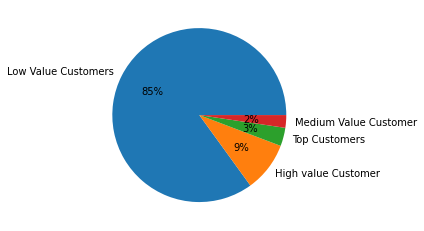

In [46]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

It's pretty strange because the highest percentage in Olist E-commerce is the low value customers. While before, most of customer give 5 star to the Olist E-commerce.

In [47]:
print(rfm_df['Frequency'].describe())

count    93357.000000
mean         1.225007
std          0.746885
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         35.000000
Name: Frequency, dtype: float64


From summary of frequency, we can conclude that most of customer only buy for 1 until 2 times in Olist E-commerce by looking the mean. The interesting part is, up until quartil 3 (75%), is still dominate with number 1. This means that most of customer only do once transaction

In [48]:
print(rfm_df['Recency'].describe())

count    93357.000000
mean       237.473783
std        152.587935
min          0.000000
25%        114.000000
50%        218.000000
75%        346.000000
max        695.000000
Name: Recency, dtype: float64


From summary of frequency, we can conclude that most of customer not do transaction at the moment. Most of them do transaction on Olist E-commerce at a long time ago. 

In [49]:
df['InvoiceDate'].max()

Timestamp('2018-08-29 00:00:00')

In [50]:
df['InvoiceDate'].min()

Timestamp('2016-10-03 00:00:00')

Also, it can be conclude that this dataset has a distant gap between max and min date. Thats why the number of recency are huge. 

# **2a. Calculate Probability to Alive with Beta-Geometry**

In [51]:
df = summary_data_from_transaction_data(
    df, 
    'CustomerID', 
    'InvoiceDate', 
    monetary_value_col='GMV', 
    observation_period_end='2018-08-29'
)

In [52]:
df

,frequency,recency,T,monetary_value
CustomerID,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,111.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,114.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,537.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,321.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,288.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,447.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,262.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,568.0,0.0


In [53]:
df_new = rfm_df.merge(df, on='CustomerID')
df_new.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment,frequency,recency,T,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,76.00,42.49,42.49,2.38,Low Value Customers,0.0,0.0,111.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,74.97,42.49,42.49,2.37,Low Value Customers,0.0,0.0,114.0,0.0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3.47,42.49,42.49,1.83,Low Value Customers,0.0,0.0,537.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,28.57,42.49,42.49,2.02,Low Value Customers,0.0,0.0,321.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,33.58,42.49,42.49,2.06,Low Value Customers,0.0,0.0,288.0,0.0


In [54]:
columns_5 = ["R_rank_norm","F_rank_norm", "M_rank_norm", "RFM_Score", "Customer_segment", "frequency", "recency", "monetary_value"]
df_new.drop(columns_5, inplace=True, axis=1)
df_new

,CustomerID,Recency,Frequency,Monetary,T
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,111.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,114.0
2,0000f46a3911fa3c0805444483337064,537,1,86.22,537.0
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,321.0
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,288.0
...,...,...,...,...,...
93352,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,4134.84,447.0
93353,fffea47cd6d3cc0a88bd621562a9d061,262,1,84.58,262.0
93354,ffff371b4d645b6ecea244b27531430a,568,1,112.46,568.0
93355,ffff5962728ec6157033ef9805bacc48,119,1,133.69,119.0


Predicted probability to alive

In [55]:
df_new = df_new.query("Frequency > 0")

In [56]:
bgf = BetaGeoFitter(penalizer_coef=2)
bgf.fit(df_new['Frequency'], df_new['Recency'], df_new['T'])

<lifetimes.BetaGeoFitter: fitted with 93357 subjects, a: 0.00, alpha: 37.59, b: 0.00, r: 0.33>

In [57]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,3.327290e-01,1.012381e-03,3.307448e-01,0.334713
alpha,3.758595e+01,2.850311e-01,3.702729e+01,38.144612
a,4.125200e-07,3.674380e-07,-3.076584e-07,0.000001
b,2.492476e-03,1.199964e-03,1.405460e-04,0.004844


Let's visualize the frequency/recency matrix

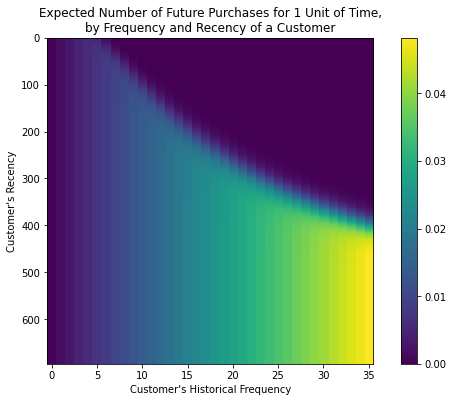

In [58]:
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

According to the graph, the more frequently customer purchase on the Olist E-commerce, the more increase number probability to do purchase again in the future. For the example, for customers that already make 35 repeat order have a great probability to make another repeat order. Customers that only purchase for once, have lower probability to make another repeat order.

Another interesting matrix to look at is the probability of still being alive

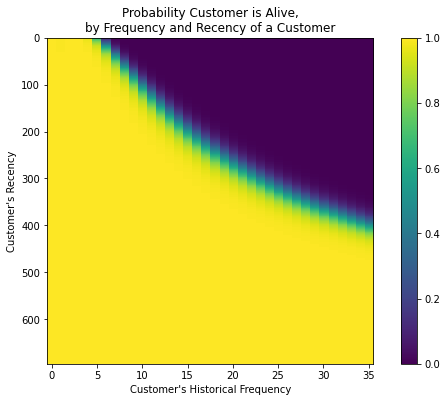

In [59]:
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

The more recent customer purchased, the more they are surely "alive". This data has a great number of recency, thats why the result of graphic above is preety unproportional.

**Predict probability to alive and repeat transaction for seven days ahead**

In [60]:
# pick period
t = 7
# predict purchases
df_new['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [61]:
df_new['prob_alive'] = bgf.conditional_probability_alive(
    df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [62]:
df_new.sort_values(by='predicted_purchases', ascending = False).head(10)

,CustomerID,Recency,Frequency,Monetary,T,predicted_purchases,prob_alive
73126,c8460e4251689ba205045f3ea17884a1,21,24,27935.46,22.0,2.858545,1.0
2626,072a543c663f0b54b41af8b074162d62,13,12,621.63,13.0,1.706582,1.0
40652,6f35424ab0a4f25807ac4e03b155832e,34,14,619.60,34.0,1.401519,1.0
35753,61b4260aa3892f7f714ba862cd42fd0e,5,8,423.16,5.0,1.369679,1.0
73377,c8ed31310fc440a3f8031b177f9842c3,17,10,11572.80,17.0,1.325050,1.0
30721,5419a7c9b86a43d8140e2939cd2c2f7e,109,24,1333.80,109.0,1.161974,1.0
38638,69aedec762e21e5aaca6eba2e635dcfb,65,16,460.64,65.0,1.114471,1.0
60526,a5c6335399140e986db84120c425adf0,35,11,5948.36,35.0,1.092899,1.0
76534,d18bffb883d8a0dfaa36528f0e2e5168,5,6,426.60,5.0,1.040932,1.0
51598,8dc697d03f771cecc2534534a73eaaf9,5,6,1303.08,5.0,1.040932,1.0


This are the top 10 of customers that have probability to alive at next week. Also, they are predicted to repurchase at least one time. Customer with ID 73126 has the highest predicted to purchase for next week.

**Predict probability to alive and repeat transaction for two weeks ahead**

In [63]:
# pick period
t = 14
# predict purchases
df_new['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [64]:
df_new['prob_alive'] = bgf.conditional_probability_alive(
    df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [65]:
df_new.sort_values(by='predicted_purchases', ascending = False).head(10)

,CustomerID,Recency,Frequency,Monetary,T,predicted_purchases,prob_alive
73126,c8460e4251689ba205045f3ea17884a1,21,24,27935.46,22.0,5.717089,1.0
2626,072a543c663f0b54b41af8b074162d62,13,12,621.63,13.0,3.413165,1.0
40652,6f35424ab0a4f25807ac4e03b155832e,34,14,619.60,34.0,2.803039,1.0
35753,61b4260aa3892f7f714ba862cd42fd0e,5,8,423.16,5.0,2.739359,1.0
73377,c8ed31310fc440a3f8031b177f9842c3,17,10,11572.80,17.0,2.650099,1.0
30721,5419a7c9b86a43d8140e2939cd2c2f7e,109,24,1333.80,109.0,2.323948,1.0
38638,69aedec762e21e5aaca6eba2e635dcfb,65,16,460.64,65.0,2.228943,1.0
60526,a5c6335399140e986db84120c425adf0,35,11,5948.36,35.0,2.185798,1.0
76534,d18bffb883d8a0dfaa36528f0e2e5168,5,6,426.60,5.0,2.081865,1.0
51598,8dc697d03f771cecc2534534a73eaaf9,5,6,1303.08,5.0,2.081865,1.0


This are the top 10 of customers that have probability to alive for two weeks ahead. If we look at the table, the person that have high probability to alive and predicted to repurchase is same like before.

**Predict probability to alive and repeat transaction for one month ahead**

In [66]:
# pick period
t = 30
# predict purchases
df_new['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [67]:
df_new['prob_alive'] = bgf.conditional_probability_alive(
    df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [68]:
df_new.sort_values(by='predicted_purchases', ascending = False).head(10)

,CustomerID,Recency,Frequency,Monetary,T,predicted_purchases,prob_alive
73126,c8460e4251689ba205045f3ea17884a1,21,24,27935.46,22.0,12.250904,1.0
2626,072a543c663f0b54b41af8b074162d62,13,12,621.63,13.0,7.313924,1.0
40652,6f35424ab0a4f25807ac4e03b155832e,34,14,619.60,34.0,6.006511,1.0
35753,61b4260aa3892f7f714ba862cd42fd0e,5,8,423.16,5.0,5.870054,1.0
73377,c8ed31310fc440a3f8031b177f9842c3,17,10,11572.80,17.0,5.678784,1.0
30721,5419a7c9b86a43d8140e2939cd2c2f7e,109,24,1333.80,109.0,4.979889,1.0
38638,69aedec762e21e5aaca6eba2e635dcfb,65,16,460.64,65.0,4.776305,1.0
60526,a5c6335399140e986db84120c425adf0,35,11,5948.36,35.0,4.683852,1.0
76534,d18bffb883d8a0dfaa36528f0e2e5168,5,6,426.60,5.0,4.461139,1.0
51598,8dc697d03f771cecc2534534a73eaaf9,5,6,1303.08,5.0,4.461139,1.0


This are the top 10 of customers that have probability to alive for two weeks ahead. If we look at the table, the number of repeat order are increase than before. Customer with ID 73126 are predicted to do until eight repeat order in one month ahead

**Predict probability to alive and repeat transaction for two months ahead**

In [69]:
# pick period
t = 60
# predict purchases
df_new['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [70]:
df_new['prob_alive'] = bgf.conditional_probability_alive(
    df_new['Frequency'], df_new['Recency'], df_new['T']
)

In [71]:
df_new.sort_values(by='predicted_purchases', ascending = False).head(10)

,CustomerID,Recency,Frequency,Monetary,T,predicted_purchases,prob_alive
73126,c8460e4251689ba205045f3ea17884a1,21,24,27935.46,22.0,24.501807,1.0
2626,072a543c663f0b54b41af8b074162d62,13,12,621.63,13.0,14.627847,1.0
40652,6f35424ab0a4f25807ac4e03b155832e,34,14,619.60,34.0,12.013022,1.0
35753,61b4260aa3892f7f714ba862cd42fd0e,5,8,423.16,5.0,11.740106,1.0
73377,c8ed31310fc440a3f8031b177f9842c3,17,10,11572.80,17.0,11.357567,1.0
30721,5419a7c9b86a43d8140e2939cd2c2f7e,109,24,1333.80,109.0,9.959778,1.0
38638,69aedec762e21e5aaca6eba2e635dcfb,65,16,460.64,65.0,9.552610,1.0
60526,a5c6335399140e986db84120c425adf0,35,11,5948.36,35.0,9.367703,1.0
76534,d18bffb883d8a0dfaa36528f0e2e5168,5,6,426.60,5.0,8.922276,1.0
51598,8dc697d03f771cecc2534534a73eaaf9,5,6,1303.08,5.0,8.922276,1.0


This are the top 10 of customers that have probability to alive for two weeks ahead. If we look at the table, the number of repeat order are increase than before. Customer with ID 73126 are predicted to do six teen repeat order in two months ahead

But wait a sec, we need to evaluate our model first to make sure if our model are able to predict both repeat order and probability to alive

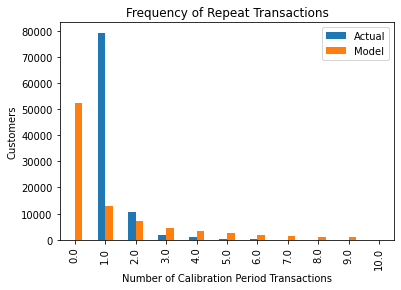

In [72]:
plot_period_transactions(bgf, max_frequency=10)

It can be infered that this model has good accuracy on predict two repeat purchase. 

# **2b. Predict total purchase of customer each month with assumption there are discount rate 1% for each month**

So far, we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But ﬁrst we need to create summary data from transactional data also containing economic values for each transaction (i.e. proﬁts or revenues).

As we are aware by now that, to create a summary dataset which contains information about every customer. We can use the summary_data_from_transaction_data function to generate a summary data frame.

The result contains four columns:
- recency — the time between the first and the last transaction
- frequency — the number of purchases beyond the initial one
- T — the time between the first purchase and the end of the calibration period
- monetary value — the arithmetic mean of customer’s transactions in the calibration period

If we have some customers who did not buy anything in the calibration period and their monetary value in the summary dataset is zero, we must remove them. After that we can build the model. We are only estimating the customers who had at least one repeat purchase with us.

In [73]:
summary = df_new[df_new['Frequency']>0]
print(summary.head())
print()
print('\nCustomers with atleast 1 repeat purchase\n', len(summary))

                         CustomerID  Recency  Frequency  Monetary      T  \
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90  111.0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19  114.0   
2  0000f46a3911fa3c0805444483337064      537          1     86.22  537.0   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62  321.0   
4  0004aac84e0df4da2b147fca70cf8255      288          1    196.89  288.0   

   predicted_purchases  prob_alive  
0             0.538076    0.999835  
1             0.527427    0.999835  
2             0.139145    0.999835  
3             0.222961    0.999835  
4             0.245559    0.999835  


Customers with atleast 1 repeat purchase
 93357


Here we estimate that there is total 93357 customers that have atleast 1 repeat purchase

*The Gamma-Gamma model and the independence assumption*

Gamma-Gamma model is based on the assumption that the number of transactions does not depend on their monetary value. The frequency and monetary value are not correlated if the output is close to zero. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [74]:
summary[['Monetary', 'Frequency']].corr()

,Monetary,Frequency
Monetary,1.000000,0.423376
Frequency,0.423376,1.000000


Wew, we have some problem here. There are moderate corelation between monetary and frequency. But, lets try to use it

In [75]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary['Frequency'],
        summary['Monetary'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 93357 subjects, p: 24.52, q: 1.67, v: 6.10>


In [76]:
print(ggf.conditional_expected_average_profit(
        summary['Frequency'],
        summary['Monetary'],
    ).head(10))

0    144.072050
1     32.406824
2     89.869977
3     48.400719
4    197.602438
5    168.486346
6     40.379435
7    830.093160
8    152.073865
9    132.254285
dtype: float64


In [77]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['Frequency'],
        summary['Monetary']
    ).mean(),
    summary[summary['Frequency']>0]['Monetary'].mean()
))

Expected conditional average profit: 214.21784800867346, Average profit: 212.98232248251335


Here, we calculate that expected average profit is 214.21. 

In [78]:
# refit the BG model to the summary_with_money_value dataset 
bgf.fit(summary['Frequency'], summary['Recency'], summary['T'])
print(ggf.customer_lifetime_value( 
    bgf, #the model to use to predict the number of future transactions 
    summary['Frequency'], 
    summary['Recency'], 
    summary['T'], 
    summary['Monetary'], 
    time=12, # months 
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually 
).head(10)) 

0     436.256065
1      96.187141
2      70.371898
3      60.729281
4     273.065117
5     412.918922
6     107.765158
7    2977.528991
8     117.849486
9     286.649591
Name: clv, dtype: float64


# **3. Then what can be interprate from the data?**

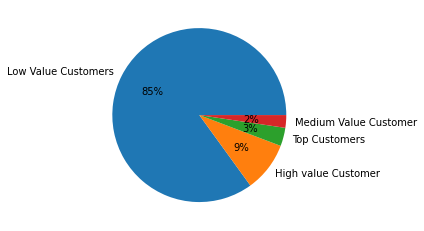

In [79]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

From the segmentation before, we can conclude that there are still huge number of low value customers in Olist E-Commerce. This can be happen because of several aspects:
- The range of dataset are too far. In e-commerce, the fluctuative of trend often happen. Therefore, the data need to be filtered first. 
- The e-commerce need to engage more! Most of customer satisfied with Olist E-commerce. But, maybe the Olist E-commerce need to add some value or do another action to enhance engagement of customers